# Text Classification - Section 5

## Machine Learning Overview

For this exercise we'll be using the **SMSSpamCollection** dataset from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) that contains more than 5 thousand SMS phone messages.<br>You can check out the [**sms_readme**](../TextFiles/sms_readme.txt) file for more info.

The file is a [tab-separated-values](https://en.wikipedia.org/wiki/Tab-separated_values) (tsv) file with four columns:
> **label** - every message is labeled as either ***ham*** or ***spam***<br>
> **message** - the message itself<br>
> **length** - the number of characters in each message<br>
> **punct** - the number of punctuation characters in each message

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':'1YBdoTqZ80R_T1o3Id1PAbPdVWeAYsOG_'}) 
downloaded.GetContentFile('smsspamcollection.tsv') 

df= pd.read_csv("smsspamcollection.tsv", sep='\t')

df.head()


,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [4]:
len(df)

5572

In [5]:
# missing values
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [6]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [7]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

We see that 4825 out of 5572 messages, or 86.6%, are ham.<br>This means that any machine learning model we create has to perform **better than 86.6%** to beat random chance.

In [8]:
df['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

This dataset is extremely skewed. The mean value is 80.5 and yet the max length is 910. Let's plot this on a logarithmic x-axis

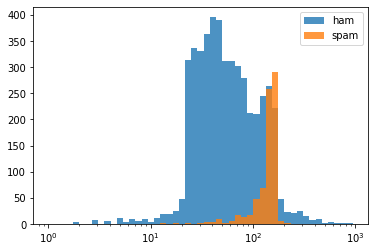

In [9]:
# visualization

import matplotlib.pyplot as plt
%matplotlib inline

plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(df[df['label']=='ham']['length'],bins=bins,alpha=0.8)
plt.hist(df[df['label']=='spam']['length'],bins=bins,alpha=0.8)
plt.legend(('ham','spam'))
plt.show()

It looks like there's a small range of values where a message is more likely to be spam than ham.</font>

Now let's look at the `punct` column:

In [10]:
df['punct'].describe()

count    5572.000000
mean        4.177495
std         4.623919
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       133.000000
Name: punct, dtype: float64

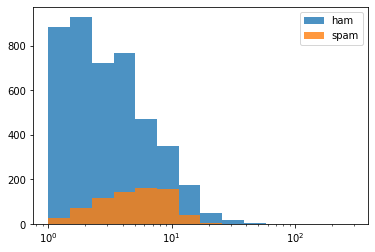

In [11]:
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df[df['label']=='ham']['punct'],bins=bins,alpha=0.8)
plt.hist(df[df['label']=='spam']['punct'],bins=bins,alpha=0.8)
plt.legend(('ham','spam'))
plt.show()

>This looks even worse - there seem to be no values where one would pick spam over ham. We'll still try to build a machine learning classification model, but we should expect poor results

___
 Split the data into train & test sets:

If we wanted to divide the DataFrame into two smaller sets, we could use
> `train, test = train_test_split(df)`

For our purposes let's also set up our Features (X) and Labels (y). The Label is simple - we're trying to predict the `label` column in our data. For Features we'll use the `length` and `punct` columns. *By convention, **X** is capitalized and **y** is lowercase.*

### Selecting features
There are two ways to build a feature set from the columns we want. If the number of features is small, then we can pass those in directly:
> `X = df[['length','punct']]`

If the number of features is large, then it may be easier to drop the Label and any other unwanted columns:
> `X = df.drop(['label','message'], axis=1)`

These operations make copies of **df**, but do not change the original DataFrame in place. All the original data is preserved.

In [12]:
# Create Feature and Label sets
X = df[['length','punct']]  # note the double set of brackets
y = df['label']

Additional train/test/split arguments:
The default test size for `train_test_split` is 30%. Here we'll assign 33% of the data for testing.<br>
Also, we can set a `random_state` seed value to ensure that everyone uses the same "random" training & testing sets.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (3733, 2)
Testing Data Shape:  (1839, 2)


Now we can pass these sets into a series of different training & testing algorithms and compare their results.

In [14]:
# creating a dictionary for displaying models' scores:

models= {}
values= {}

scores= dict(zip(models, values))


___
 Train a `Logistic Regression` classifier
One of the simplest multi-class classification tools is [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Scikit-learn offers a variety of algorithmic solvers; we'll use [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS). 

In [15]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs')

lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# test accuracy

from sklearn import metrics

# Create a prediction set:
predictions = lr_model.predict(X_test)

# Print a confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[1547   46]
 [ 241    5]]


In [17]:
# You can make the confusion matrix less confusing by adding labels:
df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['ham','spam'], columns=['ham','spam'])
df

# Explanation

# TP 1547 (Correctly 1547 hams were classified as hams)
# FN 46 (46 falsely classified as spam when they were ham)
# FP 241 (241 were classified as ham when they were spam)
# TN 5 (Trully classified as spam)

,ham,spam
ham,1547,46
spam,241,5


> These results are terrible! More spam messages were confused as ham (241) than correctly identified as spam (5), although a relatively small number of ham messages (46) were confused as spam.</font>

In [18]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))


              precision    recall  f1-score   support

         ham       0.87      0.97      0.92      1593
        spam       0.10      0.02      0.03       246

    accuracy                           0.84      1839
   macro avg       0.48      0.50      0.47      1839
weighted avg       0.76      0.84      0.80      1839



We can see from the above that:
> the model is good at detecting ham emails, but not spams

In [19]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))


0.843936922240348


In [20]:

# to add score values in dictionary for the final comparison plot
scores["logistic regression"]= metrics.accuracy_score(y_test,predictions)

___Train a `naïve Bayes classifier`:
One of the most common - and successful - classifiers is [naïve Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes).

In [21]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [22]:
# Run predictions and report on metrics
predictions = nb_model.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))


[[1583   10]
 [ 246    0]]


In [23]:
df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['ham','spam'], columns=['ham','spam'])
df


,ham,spam
ham,1583,10
spam,246,0


The total number of confusions dropped from **287** to **256**. [241+46=287, 246+10=256]

In [24]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.87      0.99      0.93      1593
        spam       0.00      0.00      0.00       246

    accuracy                           0.86      1839
   macro avg       0.43      0.50      0.46      1839
weighted avg       0.75      0.86      0.80      1839



In [25]:
print(metrics.accuracy_score(y_test,predictions))

# better but still less accuracy than 86.6%

0.8607939097335509


In [26]:
# to add score values in dictionary for the final comparison plot
scores["Naive Bayes"]= metrics.accuracy_score(y_test,predictions)

___
Train a `support vector machine (SVM)` classifier
Among the SVM options available, we'll use [C-Support Vector Classification (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [27]:
from sklearn.svm import SVC
svc_model = SVC(gamma='auto')
svc_model.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
# run predictions and report on metrics
predictions = svc_model.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))

[[1515   78]
 [ 131  115]]


In [29]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.92      0.95      0.94      1593
        spam       0.60      0.47      0.52       246

    accuracy                           0.89      1839
   macro avg       0.76      0.71      0.73      1839
weighted avg       0.88      0.89      0.88      1839



In [30]:
print(metrics.accuracy_score(y_test,predictions))

0.8863512778684067


In [31]:
# to add score values in dictionary for the final comparison plot
scores["SVM"]= metrics.accuracy_score(y_test,predictions)

And finally we have a model that performs *slightly* better than random chance.</font>

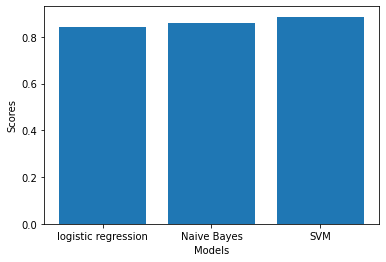

In [32]:
def plot_dict(dictionary):
  plt.bar(range(len(dictionary)), list(dictionary.values()), align= "center")
  plt.xticks(range(len(dictionary)), list(dictionary.keys()))
  plt.xlabel("Models")
  plt.ylabel("Scores")



plot_dict(scores)

# Feature Extraction from text



# Bag of Words and Tf-idf
By itself these may not be helpful until we consider *term frequencies*, or how often individual words appear in documents. A simple way to calculate term frequencies is to divide the number of occurrences of a word by the total number of words in the document. In this way, the number of times a word appears in large documents can be compared to that of smaller documents.

However, it may be hard to differentiate documents based on term frequency if a word shows up in a majority of documents. To handle this we also consider *inverse document frequency*, which is the total number of documents divided by the number of documents that contain the word. In practice we convert this value to a logarithmic scale, as described [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency).

Together these terms become [**tf-idf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

# Stop Words and Word Stems
Some words like "the" and "and" appear so frequently, and in so many documents, that we needn't bother counting them. Also, it may make sense to only record the root of a word, say `cat` in place of both `cat` and `cats`. This will shrink our vocab array and improve performance.

#Tokenization and Tagging
When we created our vectors the first thing we did was split the incoming text on whitespace with `.split()`. This was a crude form of *tokenization* - that is, dividing a document into individual words. In this simple example we didn't worry about punctuation or different parts of speech. In the real world we rely on some fairly sophisticated *morphology* to parse text appropriately.

Once the text is divided, we can go back and *tag* our tokens with information about parts of speech, grammatical dependencies, etc. This adds more dimensions to our data and enables a deeper understanding of the context of specific documents. For this reason, vectors become ***high dimensional sparse matrices***.

___
# Feature Extraction from Text !!! Here begins
# Counter Vectorisation & tfid
In the **Scikit-learn Primer** lecture we applied a simple SVC classification model to the SMSSpamCollection dataset. We tried to predict the ham/spam label based on message length and punctuation counts. In this section we'll actually look at the text of each message and try to perform a classification based on content. We'll take advantage of some of scikit-learn's [feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) tools.

## Load a dataset

In [33]:
downloaded = drive.CreateFile({'id':'1YBdoTqZ80R_T1o3Id1PAbPdVWeAYsOG_'}) 
downloaded.GetContentFile('smsspamcollection.tsv') 

df= pd.read_csv("smsspamcollection.tsv", sep='\t')

df.head()


,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [34]:
# missing values
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [35]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

4825 out of 5572 messages, or 86.6%, are ham. This means that any text classification model we create has to perform **better than 86.6%** to beat random chance.</font>

## Split into train test

In [36]:
# Split data into train - test

from sklearn.model_selection import train_test_split

X = df['message']  # this time we want to look at the text
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Scikit-learn's CountVectorizer
Text preprocessing, tokenizing and the ability to filter out stopwords are all included in [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which builds a dictionary of features and transforms documents to feature vectors.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

# fit vectorizer to the data (build a vocab, count the number of words..)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

#7082= features = vocab counts

(3733, 7082)

In [38]:
X_train_counts # because lot's of zeros

<3733x7082 sparse matrix of type '<class 'numpy.int64'>'
	with 49992 stored elements in Compressed Sparse Row format>

This shows that our training set is comprised of 3733 documents, and 7082 features.</font>

## Transform Counts to Frequencies with Tf-idf
While counting words is helpful, longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid this we can simply divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called **tf** for Term Frequencies.

Another refinement on top of **tf** is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called **tf–idf** for “Term Frequency times Inverse Document Frequency”.

Both tf and tf–idf can be computed as follows using [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html):

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3733, 7082)

Note: the `fit_transform()` method actually performs two operations: it fits an estimator to the data and then transforms our count-matrix to a tf-idf representation.

# Combine Counter Vectorizer & TF-IDF with TfidVectorizer in one step !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Hence, you can ignore the previous steps, because with scikit learn you can combine them as below: 


We can combine the CountVectorizer and TfidTransformer steps into one using [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

#So after splitting into train/test, we can do this:
X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(3733, 7082)

## Train a Classifier
Here we'll introduce an SVM classifier that's similar to SVC, called [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). LinearSVC handles sparse input better, and scales well to large numbers of samples.

In [41]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Earlier we named our SVC classifier **svc_model**. Here we're using the more generic name **clf** (for classifier)

## Build a Pipeline
Remember that only our training set has been vectorized into a full vocabulary. In order to perform an analysis on our `test` set we'll have to submit it to the same procedures. Fortunately scikit-learn offers a [**Pipeline**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class that behaves like a compound classifier.

In [42]:
from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import LinearSVC

# Pipeline for transfering tfid vectorisation
text_classifier = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()), # classification using LinearSVC
])

# Feed the training data through the pipeline
text_classifier.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

## Test the classifier and display results

In [43]:
# Form a prediction set
# "text_classifier" carries the pipelines tranformations we gave it
predictions = text_classifier.predict(X_test)

# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[1586    7]
 [  12  234]]


In [44]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1593
        spam       0.97      0.95      0.96       246

    accuracy                           0.99      1839
   macro avg       0.98      0.97      0.98      1839
weighted avg       0.99      0.99      0.99      1839



In [45]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.989668297988037


In [46]:
text_classifier.predict(["hey how are you doing"])
# it shows that this message is ham

array(['ham'], dtype=object)

In [47]:
text_classifier.predict(["Give your details to enter to this competition"])

array(['ham'], dtype=object)

Using the text of the messages, our model performed exceedingly well; it correctly predicted spam **98.97%** of the time!<br>
Now let's apply what we've learned to a text classification project involving positive and negative movie reviews.